## Torch CNN Demo

### Torch quick start
 - [Torch quickstart tutorials](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)
 - [Official documant](https://pytorch.org/tutorials/beginner/basics/intro.html)
 - [Youtube tutorials](https://pytorch.org/tutorials/beginner/introyt.html)


### Summary
 - Following quickstart tutorial offered by the official document, build CNN classificator with fashion-MNIST dataset.

### Create conda environment
 - [How to use conda](https://www.machinelearningplus.com/deployment/conda-create-environment-and-everything-you-need-to-know-to-manage-conda-virtual-environment/)

 
 - Create environment
     - `conda create --name {env_name} python=={version}`
     - `conda create --name {env_name} python=={version} {package names}`
     - `conda create --name torch-demo python==3.7.5 numpy pandas`
 - Activate environment
     - `conda activate {env_name}`
 - Deactivate environment
     - `conda deactivate {env_name}`
 - Install packages
     - `conda install {package_name}==1.x.y {package_name}==1.x.y {package_name}==1.x.y ...`
 - List packages
     - `conda list`
     - `conda list -n {env_name}`
 - List envs
     - `conda env list`
     - `conda info --envs`
 - Remove envs
     - `conda env remove -n {env_name}`


#### Import Libraries

In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

#### Prepare dataset

In [2]:
# Download training data from open datasets.
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


'''
# For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. 
# To make these transformations, we use ToTensor and Lambda.

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

'''

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


#### NN Model

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
# layers -> https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295212  [    0/60000]
loss: 2.297016  [ 6400/60000]
loss: 2.270131  [12800/60000]
loss: 2.276766  [19200/60000]
loss: 2.257899  [25600/60000]
loss: 2.216562  [32000/60000]
loss: 2.241641  [38400/60000]
loss: 2.192044  [44800/60000]
loss: 2.190249  [51200/60000]
loss: 2.172081  [57600/60000]
Test Error: 
 Accuracy: 38.4%, Avg loss: 2.162446 

Epoch 2
-------------------------------
loss: 2.162574  [    0/60000]
loss: 2.166365  [ 6400/60000]
loss: 2.103726  [12800/60000]
loss: 2.133069  [19200/60000]
loss: 2.079629  [25600/60000]
loss: 2.011828  [32000/60000]
loss: 2.055794  [38400/60000]
loss: 1.962720  [44800/60000]
loss: 1.969165  [51200/60000]
loss: 1.916114  [57600/60000]
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.909243 

Epoch 3
-------------------------------
loss: 1.931545  [    0/60000]
loss: 1.914586  [ 6400/60000]
loss: 1.793185  [12800/60000]
loss: 1.846885  [19200/60000]
loss: 1.730652  [25600/60000]
loss: 1.677369  [32000/600

In [9]:
torch.save(model.state_dict(), "models/demo_model.pth")
print("Saved PyTorch Model State to models/demo_model.pth")

Saved PyTorch Model State to models/demo_model.pth


In [12]:
model = NeuralNetwork()
model.load_state_dict(torch.load("models/demo_model.pth"))

<All keys matched successfully>

In [13]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [19]:
# Tensor
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
print(x_data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print(x_np)

tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]])


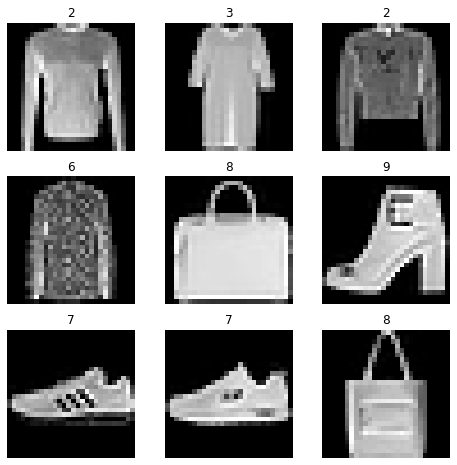

In [22]:
# Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()